# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500) # dataframes
import numpy as np # mathsy bits
import ipywidgets as widgets # widgets

from sklearn.model_selection import train_test_split #split data into train and test sets

# feature selection + gridsearch
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV

# models
from sklearn.linear_model import Lars, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import joblib # saving models
from datetime import datetime # get time for labelling saved models

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import mpld3 # hover-over labels for plots
mpld3.disable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [49]:
def grid_search_return_hp_dict(model, X_train_gs, y_train_gs, param_grid):
    """Run GridSearchCV on given model with defined param_grid, return best params as dict.
    Pre-assign sklearn model to variable. Pass param_grid as dict."""
    print(str(model).split(sep='(')[0], "grid search.")
    GS = GridSearchCV(model, param_grid, n_jobs=2)
    GS.fit(X_train_gs, y_train_gs)
    print(GS.best_params_)
    return(GS.best_params_)

def produce_exp_vs_pred_df(features_list, model, codename):
    """Pass features_list as a string"""
    pred_list = []
    for i in range(0, len(dragon_features)):
        prediction = model.predict([dragon_features[eval(features_list)].iloc[i]])
        pred_list.append(prediction)
    train_scores.update({codename : model.score(X_train, y_train)})
    test_scores.update({codename : model.score(X_test, y_test)})
    
    print('Training Score:\t', model.score(X_train, y_train))
    print('Testing Score:\t', model.score(X_test, y_test))
    
    exp_vs_calc = pd.DataFrame(constants_first)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    
    now = datetime.now()

    dt_string = now.strftime("_%d_%m_%Y_%H_%M_%S")
    filename = "models/DRAGON_noVPAS/" + str(model).split(sep='(')[0] + "_" + features_list[16:] + dt_string + ".joblib"
    print(str(model).split(sep='(')[0], "run at:", now, ". Saving to", filename)
    
    joblib.dump(model, filename)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    #print('Training Score:\t', model_func.score(X_train, y_train))
    #print('Testing Score:\t', model_func.score(X_test, y_test))
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    labels = ['{}'.format(i) for i in species_names]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# DRAGON descriptors
## Bringing in data and splitting it into parts

In [3]:
csv = pd.read_csv('filtered_organics_desc_kh.csv') # contains VP/AS HLCs

print("Input Shape", csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print("Removed NaN, new shape", csv.shape) #removed NaN shape

smiles_strings = csv.pop('Unnamed: 0')
species_names = csv.pop('0')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features

X_train_main, X_test_main, y_train, y_test = train_test_split(dragon_features, constants_first, test_size=0.3)

Input Shape (2075, 1480)
Removed NaN, new shape (2068, 1480)


In [4]:
X_test_main.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,nAT,nSK,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nS,nF,nCL,nBR,nI,nHM,nHet,nX,H%,C%,N%,O%,X%,nCsp3,nCsp2,nCsp,nCIC,nCIR,TRS,Rperim,Rbrid,MCD,RFD,RCI,NRS,NNRS,nR03,nR04,nR05,nR06,nR07,nR08,nR09,nR10,nR11,nR12,nBnz,ARR,D/Dtr03,D/Dtr04,D/Dtr05,D/Dtr06,D/Dtr07,D/Dtr08,D/Dtr09,D/Dtr10,D/Dtr11,D/Dtr12,Wap,S1K,S2K,S3K,PHI,PW2,PW3,PW4,PW5,MAXDN,MAXDP,DELS,TIE,Psi_i_s,Psi_i_A,Psi_i_0,Psi_i_1,Psi_i_t,Psi_i_0d,Psi_i_1d,Psi_i_1s,Psi_e_A,Psi_e_0,Psi_e_t,Psi_e_0d,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,MPC01,MPC02,MPC03,MPC04,MPC05,MPC06,MPC07,MPC08,MPC09,MPC10,piPC01,piPC02,piPC03,piPC04,piPC05,piPC06,piPC07,piPC08,piPC09,piPC10,TWC,TPC,piID,PCD,CID,BID,ISIZ,IAC,AAC,IDE,IDM,IDDE,IDDM,IDET,IDMT,IVDE,IVDM,S0K,HVcpx,HDcpx,Uindex,Vindex,Xindex,Yindex,IC0,IC1,IC2,IC3,IC4,IC5,TIC0,TIC1,TIC2,TIC3,TIC4,TIC5,SIC0,SIC1,SIC2,SIC3,SIC4,SIC5,CIC0,CIC1,CIC2,CIC3,CIC4,CIC5,BIC0,BIC1,BIC2,BIC3,BIC4,BIC5,ATS1m,ATS2m,ATS3m,ATS4m,ATS5m,ATS6m,ATS7m,ATS8m,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,ATS6v,ATS7v,ATS8v,ATS1e,ATS2e,ATS3e,ATS4e,ATS5e,ATS6e,ATS7e,ATS8e,ATS1p,ATS2p,ATS3p,ATS4p,ATS5p,ATS6p,ATS7p,ATS8p,ATS1i,ATS2i,ATS3i,ATS4i,ATS5i,ATS6i,ATS7i,ATS8i,ATSC1m,ATSC2m,ATSC3m,ATSC4m,ATSC5m,ATSC6m,ATSC7m,ATSC8m,ATSC1v,ATSC2v,ATSC3v,ATSC4v,ATSC5v,ATSC6v,ATSC7v,ATSC8v,ATSC1e,ATSC2e,ATSC3e,...,F02[Cl-Cl],F02[Cl-Br],F02[Cl-I],F02[Br-Br],F02[I-I],F03[C-C],F03[C-N],F03[C-O],F03[C-S],F03[C-F],F03[C-Cl],F03[C-Br],F03[C-I],F03[N-N],F03[N-O],F03[N-S],F03[N-F],F03[N-Cl],F03[N-Br],F03[O-O],F03[O-S],F03[O-F],F03[O-Cl],F03[O-Br],F03[O-I],F03[S-S],F03[S-F],F03[S-Cl],F03[F-F],F03[F-Cl],F03[F-Br],F03[Cl-Cl],F03[Cl-Br],F03[Br-Br],F04[C-C],F04[C-N],F04[C-O],F04[C-S],F04[C-F],F04[C-Cl],F04[C-Br],F04[C-I],F04[N-N],F04[N-O],F04[N-S],F04[N-F],F04[N-Cl],F04[N-Br],F04[N-I],F04[O-O],F04[O-S],F04[O-F],F04[O-Cl],F04[O-Br],F04[O-I],F04[S-S],F04[S-F],F04[S-Cl],F04[F-F],F04[F-Cl],F04[F-Br],F04[Cl-Cl],F04[Cl-Br],F04[Br-Br],F04[I-I],F05[C-C],F05[C-N],F05[C-O],F05[C-S],F05[C-F],F05[C-Cl],F05[C-Br],F05[C-I],F05[N-N],F05[N-O],F05[N-S],F05[N-F],F05[N-Cl],F05[N-Br],F05[N-I],F05[O-O],F05[O-S],F05[O-F],F05[O-Cl],F05[O-Br],F05[S-S],F05[S-F],F05[S-Cl],F05[F-F],F05[F-Cl],F05[F-Br],F05[Cl-Cl],F05[Cl-Br],F05[Br-Br],F06[C-C],F06[C-N],F06[C-O],F06[C-S],F06[C-F],F06[C-Cl],F06[C-Br],F06[C-I],F06[N-N],F06[N-O],F06[N-S],F06[N-F],F06[N-Cl],F06[N-Br],F06[N-I],F06[O-O],F06[O-S],F06[O-F],F06[O-Cl],F06[O-Br],F06[O-I],F06[S-S],F06[S-F],F06[S-Cl],F06[F-F],F06[F-Cl],F06[Cl-Cl],F06[Cl-Br],F06[Br-Br],F07[C-C],F07[C-N],F07[C-O],F07[C-S],F07[C-F],F07[C-Cl],F07[C-Br],F07[C-I],F07[N-N],F07[N-O],F07[N-S],F07[N-F],F07[N-Cl],F07[N-Br],F07[O-O],F07[O-S],F07[O-F],F07[O-Cl],F07[O-Br],F07[S-S],F07[S-F],F07[S-Cl],F07[F-F],F07[F-Cl],F07[Cl-Cl],F07[Cl-Br],F07[Br-Br],F08[C-C],F08[C-N],F08[C-O],F08[C-S],F08[C-F],F08[C-Cl],F08[C-Br],F08[C-I],F08[N-N],F08[N-O],F08[N-S],F08[N-F],F08[N-Cl],F08[N-Br],F08[O-O],F08[O-S],F08[O-F],F08[O-Cl],F08[O-Br],F08[S-Cl],F08[F-F],F08[F-Cl],F08[Cl-Cl],F08[Cl-Br],F08[Br-Br],F09[C-C],F09[C-N],F09[C-O],F09[C-S],F09[C-F],F09[C-Cl],F09[C-Br],F09[C-I],F09[N-N],F09[N-O],F09[N-S],F09[N-F],F09[N-Cl],F09[N-Br],F09[O-O],F09[O-S],F09[O-F],F09[O-Cl],F09[O-Br],F09[F-F],F09[F-Cl],F09[Cl-Cl],F09[Br-Br],F10[C-C],F10[C-N],F10[C-O],F10[C-S],F10[C-F],F10[C-Cl],F10[C-Br],F10[C-I],F10[N-N],F10[N-O],F10[N-S],F10[N-F],F10[N-Cl],F10[O-O],F10[O-S],F10[O-F],F10[O-Cl],F10[O-Br],F10[S-F],F10[F-F],F10[F-Cl],F10[Cl-Cl],F10[Br-Br],Uc,Ui,Hy,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,SAtot,SAacc,SAdon,Vx,VvdwMG,VvdwZAZ,PDI,BLTF96,BLTD48,BLTA96,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_07,DLS_cons,LLS_01,LLS_02,Index
1185,383.40,8.157,29.825,48.669,30.012,53.922,0.635,1.036,0.639,1.147,47.0,27.0,48.0,28.0,13.0,35.0,9.0,0.188,1.0,0.0,12.0,20.0,19.0,1.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,8.0,3.0,42.6,40.4,2.1,8.5,6.4,7.0,12.0,0.0,2.0,2.0,12.0,12.0,0.0,0.444,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.429,0.0,0.0,0.0,212.263,0.0,0.0,0.

## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

In [5]:
fs_model = GradientBoostingRegressor()
fs_model.fit(X_train_main, y_train)
importances = pd.Series(fs_model.feature_importances_, index = X_train_main.columns)
top_15_features_model = list(importances.nlargest(15).index.values)

In [6]:
top_15_features_model

['TPSA(NO)',
 'P_VSA_p_2',
 'IC0',
 'Me',
 'H-050',
 'nHDon',
 'F01[C-N]',
 'Index',
 'CATS2D_02_DA',
 'T(O..O)',
 'SAdon',
 'GATS1v',
 'MATS1e',
 'LLS_02',
 'SAacc']

### Importances via 'dummy' LASSO model

In [7]:
dummy_lasso = Lasso(max_iter=10000, alpha=0.5)
selector = SelectFromModel(dummy_lasso).fit(X_train_main, y_train)
coefs = selector.estimator_.coef_
importances_lasso = pd.Series(coefs, index = X_train_main.columns)
top_15_features_lasso = list(importances_lasso.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

In [8]:
fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X_train_main, y_train)
scores_f = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

In [9]:
fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X_train_main, y_train)
scores_mutual = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

### Feature Selection results

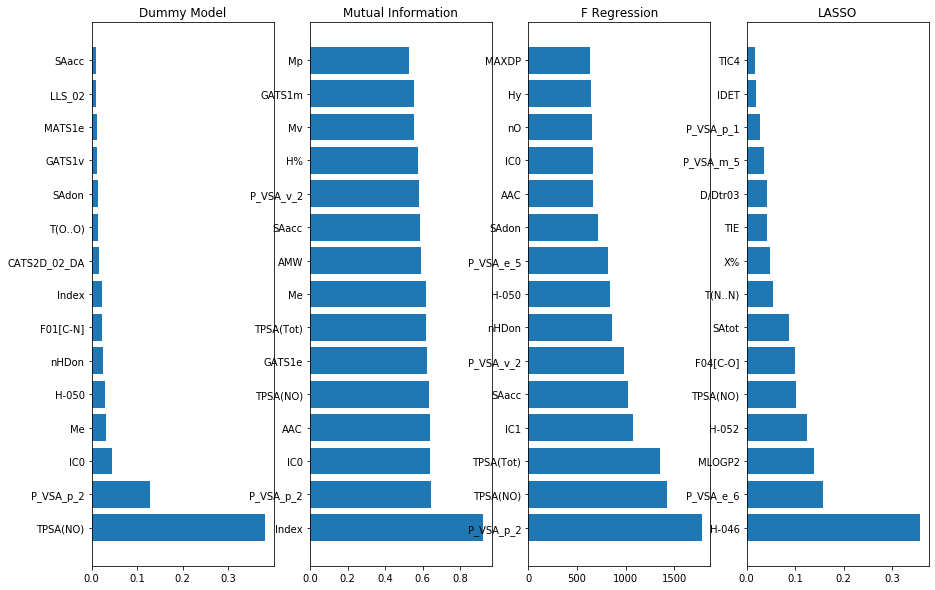

In [10]:
fig, imp_plot = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
imp_plot[0].barh(importances.nlargest(15).index.values, importances.nlargest(15))
imp_plot[0].set_title('Dummy Model')
imp_plot[1].barh(scores_mutual.nlargest(15).index.values, scores_mutual.nlargest(15))
imp_plot[1].set_title('Mutual Information')
imp_plot[2].barh(scores_f.nlargest(15).index.values, scores_f.nlargest(15))
imp_plot[2].set_title('F Regression')
imp_plot[3].barh(importances_lasso.nlargest(15).index.values, importances_lasso.nlargest(15))
imp_plot[3].set_title('LASSO')
plt.show()

## GradientBoosting
### Model-chosen features

In [11]:
gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
} #hyperparameters for each gbr grid search

In [12]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]


best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(),
                                     X_train, y_train, gbr_param_grid)

gbr_model = GradientBoostingRegressor(**best_hp)
gbr_model.fit(X_train, y_train)

exp_vs_calc_gbr_model = produce_exp_vs_pred_df('top_15_features_model', gbr_model,
                                         "GradBoost, model-chosen features")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 9, 'n_estimators': 2000}
Training Score:	 0.9136506916481263
Testing Score:	 0.8532764923340206
GradientBoostingRegressor run at: 2020-01-16 13:31:54.501366 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_model_16_01_2020_13_31_54.joblib


### F-regression features

In [13]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]

best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(),
                                     X_train, y_train, gbr_param_grid)

gbr_freg = GradientBoostingRegressor(**best_hp)
gbr_freg.fit(X_train, y_train)

exp_vs_calc_gbr_freg = produce_exp_vs_pred_df('top_15_features_kbest', gbr_freg,
                                                    "GradBoost, f_reg features")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 500}
Training Score:	 0.9317395172085381
Testing Score:	 0.8411981283092483
GradientBoostingRegressor run at: 2020-01-16 14:33:39.559393 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_kbest_16_01_2020_14_33_39.joblib


### Mutual info features

In [14]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]


best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(),
                                     X_train, y_train, gbr_param_grid)

gbr_mu = GradientBoostingRegressor(**best_hp)
gbr_mu.fit(X_train, y_train)

exp_vs_calc_gbr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', gbr_mu,
                                            "GradBoost, Mutual Info")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 2000}
Training Score:	 0.9379608336062498
Testing Score:	 0.8544833146624162
GradientBoostingRegressor run at: 2020-01-16 15:38:51.112718 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_mutual_info_16_01_2020_15_38_51.joblib


### LASSO features

In [15]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

best_hp = grid_search_return_hp_dict(GradientBoostingRegressor(), 
                                     X_train, y_train, gbr_param_grid)

gbr_lasso = GradientBoostingRegressor(**best_hp)
gbr_lasso.fit(X_train, y_train)
exp_vs_calc_gbr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', gbr_lasso,
                                               "LASSO-features, GBR model")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.02, 'loss': 'ls', 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 2000}
Training Score:	 0.996589735091017
Testing Score:	 0.8161460167193553
GradientBoostingRegressor run at: 2020-01-16 16:37:06.990069 . Saving to models/DRAGON_noVPAS/GradientBoostingRegressor_lasso_16_01_2020_16_37_06.joblib


## Decision Tree
### Model-Chosen Features

In [16]:
dtr_param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'], #function measuring quality of a split
    'max_depth': [5, 10, 20] , # max depth of tree
    'max_features': [5, 10, 15], # N features to be considered when looking for split
    'max_leaf_nodes': [None, 10, 15, 20, 30], #grows tree with N nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [1.0, 2, 3],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.5] , 
    'splitter': ['best', 'random']
} #hyperparameters for dtr gridsearch

In [17]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]

best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_model = DecisionTreeRegressor(**best_hp)

dtr_model.fit(X_train, y_train)

exp_vs_calc_dtr_model = produce_exp_vs_pred_df('top_15_features_model', dtr_model,
                                         "Decision Tree, model-chosen features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mse', 'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Training Score:	 0.9141647290701933
Testing Score:	 0.7956771880980333
DecisionTreeRegressor run at: 2020-01-16 16:40:54.355856 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_model_16_01_2020_16_40_54.joblib


### F-regression features

In [18]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]


best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_freg = DecisionTreeRegressor(**best_hp)

dtr_freg.fit(X_train, y_train)

exp_vs_calc_dtr_freg = produce_exp_vs_pred_df('top_15_features_kbest', dtr_freg,
                                         "Decision Tree, freg features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mae', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Training Score:	 0.824735879420048
Testing Score:	 0.7707477970128914
DecisionTreeRegressor run at: 2020-01-16 16:44:48.335723 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_kbest_16_01_2020_16_44_48.joblib


### Mutual info features

In [19]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]

best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_mu = DecisionTreeRegressor(**best_hp)

dtr_mu.fit(X_train, y_train)

exp_vs_calc_dtr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', dtr_mu,
                                         "Decision Tree, mutual info features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Training Score:	 0.8595461536744464
Testing Score:	 0.7715041249308991
DecisionTreeRegressor run at: 2020-01-16 16:49:12.276174 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_mutual_info_16_01_2020_16_49_12.joblib


### LASSO features

In [20]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

best_hp = grid_search_return_hp_dict(DecisionTreeRegressor(), X_train, y_train, dtr_param_grid)

dtr_lasso = DecisionTreeRegressor(**best_hp)

dtr_lasso.fit(X_train, y_train)

exp_vs_calc_dtr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', dtr_lasso,
                                         "Decision Tree, lasso features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mae', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Training Score:	 0.8840999565633477
Testing Score:	 0.7448102791928264
DecisionTreeRegressor run at: 2020-01-16 16:53:05.172089 . Saving to models/DRAGON_noVPAS/DecisionTreeRegressor_lasso_16_01_2020_16_53_05.joblib


## AdaBoost Regressor
### Model Chosen Features

In [21]:
base_models = [ExtraTreesRegressor(n_estimators= 5,
                                   criterion= 'mse',
                                   max_features = 'log2'),
               RandomForestRegressor(n_estimators= 5,
                                     criterion= 'mse',
                                     max_features = 'sqrt',
                                     min_samples_split = 3),
              GradientBoostingRegressor(),
              DecisionTreeRegressor(),
              Lars(),
              ElasticNet()]

ada_param_grid = {
    'base_estimator' : base_models, 
    'learning_rate' : [0.3, 0.5, 0.8, 1], 
    'loss' : ['linear', 'square', 'exponential'], 
    'n_estimators' : [50, 100]
} #hyperparameters for adaboost gridsearch

In [22]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_model = AdaBoostRegressor(**best_hp)

ada_model.fit(X_train, y_train)

exp_vs_calc_ada_model = produce_exp_vs_pred_df('top_15_features_model', ada_model,
                                               "AdaBoost, model features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.8, 'loss': 'square', 'n_estimators': 50}
Training Score:	 0.9966830903147815
Testing Score:	 0.8520725299365427
AdaBoostRegressor run at: 2020-01-16 17:01:08.526492 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_model_16_01_2020_17_01_08.joblib


### F-regression features

In [23]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_freg = AdaBoostRegressor(**best_hp)

ada_freg.fit(X_train, y_train)

exp_vs_calc_ada_freg = produce_exp_vs_pred_df('top_15_features_kbest', ada_freg,
                                               "AdaBoost, freg features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.8, 'loss': 'exponential', 'n_estimators': 50}
Training Score:	 0.9979723730365371
Testing Score:	 0.8433963130222173
AdaBoostRegressor run at: 2020-01-16 17:09:17.903303 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_kbest_16_01_2020_17_09_17.joblib


### Mutual info features

In [24]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_mu = AdaBoostRegressor(**best_hp)

ada_mu.fit(X_train, y_train)

exp_vs_calc_ada_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', ada_mu,
                                               "AdaBoost, mutual info features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.8, 'loss': 'exponential', 'n_estimators': 100}
Training Score:	 0.9997045578005971
Testing Score:	 0.8365182791277487
AdaBoostRegressor run at: 2020-01-16 17:18:49.229088 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_mutual_info_16_01_2020_17_18_49.joblib


### LASSO features

In [25]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

best_hp = grid_search_return_hp_dict(AdaBoostRegressor(), X_train, y_train, ada_param_grid)

ada_lasso = AdaBoostRegressor(**best_hp)

ada_lasso.fit(X_train, y_train)

exp_vs_calc_ada_lasso = produce_exp_vs_pred_df('top_15_features_lasso', ada_lasso,
                                               "AdaBoost, model features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'base_estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 50}
Training Score:	 0.9926354574810684
Testing Score:	 0.8080655222178783
AdaBoostRegressor run at: 2020-01-16 17:26:34.046134 . Saving to models/DRAGON_noVPAS/AdaBoostRegressor_lasso_16_01_2020_17_26_34.joblib


## LASSO
### Model Chosen Features

In [26]:
lasso_param_grid = {
    'alpha':[0.2, 0.4, 0.6, 0.8],
    'max_iter':[1000, 5000, 10000, 50000],
    'selection':['cyclic', 'random']
}

In [27]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_model = Lasso(**best_hp)
lasso_model.fit(X_train, y_train)

exp_vs_calc_lasso_model = produce_exp_vs_pred_df('top_15_features_model', lasso_model,
                                                 "LASSO, model features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 1000, 'selection': 'cyclic'}
Training Score:	 0.7025515174084993
Testing Score:	 0.7357933019197427
Lasso run at: 2020-01-16 17:26:40.950674 . Saving to models/DRAGON_noVPAS/Lasso_model_16_01_2020_17_26_40.joblib


### F-regression features

In [28]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_freg = Lasso(**best_hp)
lasso_freg.fit(X_train, y_train)

exp_vs_calc_lasso_freg = produce_exp_vs_pred_df('top_15_features_kbest', lasso_freg,
                                                 "LASSO, f-reg features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.95777664966954, tolerance: 7.861287863090288
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.1372885694509, tolerance: 7.861287863090288
  positive)


{'alpha': 0.2, 'max_iter': 5000, 'selection': 'random'}
Training Score:	 0.7247376293705728
Testing Score:	 0.7171477393839785
Lasso run at: 2020-01-16 17:26:48.526732 . Saving to models/DRAGON_noVPAS/Lasso_kbest_16_01_2020_17_26_48.joblib


### Mutual info features

In [29]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_mu = Lasso(**best_hp)
lasso_mu.fit(X_train, y_train)

exp_vs_calc_lasso_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lasso_mu,
                                                 "LASSO, mutual info features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 5000, 'selection': 'cyclic'}
Training Score:	 0.6858987473879607
Testing Score:	 0.6714929045146443
Lasso run at: 2020-01-16 17:26:56.280489 . Saving to models/DRAGON_noVPAS/Lasso_mutual_info_16_01_2020_17_26_56.joblib


### LASSO Features

In [30]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]
best_hp = grid_search_return_hp_dict(Lasso(), X_train, y_train, lasso_param_grid)
lasso_lasso = Lasso(**best_hp)
lasso_lasso.fit(X_train, y_train)

exp_vs_calc_lasso_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lasso_lasso,
                                                 "LASSO, lasso features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 1000, 'selection': 'cyclic'}
Training Score:	 0.6833898806906213
Testing Score:	 0.6737594517258707
Lasso run at: 2020-01-16 17:27:02.303930 . Saving to models/DRAGON_noVPAS/Lasso_lasso_16_01_2020_17_27_02.joblib


## Random Forest Regressor
### Model Chosen Features

In [31]:
random_forest_param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

In [33]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_model = RandomForestRegressor(**best_hp)
random_forest_model.fit(X_train, y_train)
exp_vs_calc_random_forest_model = produce_exp_vs_pred_df('top_15_features_model', random_forest_model,
                                                         "RandomForest, model features")

RandomForestRegressor grid search.
{'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Training Score:	 0.9774090544159082
Testing Score:	 0.8582042794564964
RandomForestRegressor run at: 2020-01-16 21:45:18.928355 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_model_16_01_2020_21_45_18.joblib


### F-regression features

In [34]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_freg = RandomForestRegressor(**best_hp)
random_forest_freg.fit(X_train, y_train)
exp_vs_calc_random_forest_freg = produce_exp_vs_pred_df('top_15_features_kbest', random_forest_freg,
                                                         "RandomForest, freg features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Score:	 0.9721752491187455
Testing Score:	 0.8401657504277648
RandomForestRegressor run at: 2020-01-17 01:11:15.379690 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_kbest_17_01_2020_01_11_15.joblib


### Mutual info features

In [35]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_mu = RandomForestRegressor(**best_hp)
random_forest_mu.fit(X_train, y_train)
exp_vs_calc_random_forest_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', random_forest_mu,
                                                         "RandomForest, mutual info features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Training Score:	 0.9729434173898541
Testing Score:	 0.8415611230823128
RandomForestRegressor run at: 2020-01-17 03:47:08.433069 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_mutual_info_17_01_2020_03_47_08.joblib


### LASSO features

In [36]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]
best_hp = grid_search_return_hp_dict(RandomForestRegressor(),
                                     X_train, y_train, random_forest_param_grid)
random_forest_lasso = RandomForestRegressor(**best_hp)
random_forest_lasso.fit(X_train, y_train)
exp_vs_calc_random_forest_lasso = produce_exp_vs_pred_df('top_15_features_lasso', random_forest_lasso,
                                                         "RandomForest, lasso features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Score:	 0.9714625413023873
Testing Score:	 0.810773797396149
RandomForestRegressor run at: 2020-01-17 05:55:00.292476 . Saving to models/DRAGON_noVPAS/RandomForestRegressor_lasso_17_01_2020_05_55_00.joblib


## LARS - Least angle regression
### Model chosen features

In [37]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]

lars_model = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_model.fit(X_train, y_train)
exp_vs_calc_lars_model = produce_exp_vs_pred_df('top_15_features_model', lars_model, "LARS model features")

Training Score:	 -5.118873363102049
Testing Score:	 -4.66823156501682
Lars run at: 2020-01-17 05:55:14.653620 . Saving to models/DRAGON_noVPAS/Lars_model_17_01_2020_05_55_14.joblib


### F-regression features

In [38]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]

lars_freg = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_freg.fit(X_train, y_train)
exp_vs_calc_lars_freg = produce_exp_vs_pred_df('top_15_features_kbest', lars_freg, "LARS freg features")

Training Score:	 0.412098008114794
Testing Score:	 0.36890756929970014
Lars run at: 2020-01-17 05:55:28.063264 . Saving to models/DRAGON_noVPAS/Lars_kbest_17_01_2020_05_55_28.joblib


### Mutual info features

In [39]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]

lars_mu = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_mu.fit(X_train, y_train)
exp_vs_calc_lars_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lars_mu, "LARS mutual info features")

Training Score:	 -4.03397309481404
Testing Score:	 -3.6461882169232736
Lars run at: 2020-01-17 05:55:41.943866 . Saving to models/DRAGON_noVPAS/Lars_mutual_info_17_01_2020_05_55_41.joblib


### LASSO features

In [40]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]

lars_lasso = Lars(fit_intercept=False, n_nonzero_coefs=np.inf)
lars_lasso.fit(X_train, y_train)
exp_vs_calc_lars_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lars_lasso, "LARS lasso features")

Training Score:	 0.6395259500652293
Testing Score:	 0.6194334350344687
Lars run at: 2020-01-17 05:55:56.217585 . Saving to models/DRAGON_noVPAS/Lars_lasso_17_01_2020_05_55_56.joblib


## Elastic Net (linear regression l1 l2 norm regularization)
### Model chosen features

In [41]:
net_param_grid = {
    'alpha':[0.1, 0.3, 0.5, 0.8, 1.0],
    'l1_ratio':[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'fit_intercept':[True, False],
    'max_iter': [1000, 3000, 5000],
    'tol':[0.0001, 0.001, 0.01],
    'selection':['cyclic', 'random']
}

In [42]:
X_train, X_test = X_train_main[top_15_features_model], X_test_main[top_15_features_model]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_model = ElasticNet(**best_hp)
net_model.fit(X_train, y_train)
exp_vs_calc_net_model = produce_exp_vs_pred_df('top_15_features_model', net_model, "ElasticNet model features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 0.8, 'max_iter': 3000, 'selection': 'cyclic', 'tol': 0.0001}
Training Score:	 0.7134538033619403
Testing Score:	 0.7453632055451128
ElasticNet run at: 2020-01-17 05:56:58.961798 . Saving to models/DRAGON_noVPAS/ElasticNet_model_17_01_2020_05_56_58.joblib


### F regression features

In [43]:
X_train, X_test = X_train_main[top_15_features_kbest], X_test_main[top_15_features_kbest]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_freg = ElasticNet(**best_hp)
net_freg.fit(X_train, y_train)
exp_vs_calc_net_freg = produce_exp_vs_pred_df('top_15_features_kbest', net_freg, "ElasticNet freg features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10978.14596703574, tolerance: 78.61287863090288
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10979.363160643945, tolerance: 78.61287863090288
  positive)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'max_iter': 3000, 'selection': 'random', 'tol': 0.001}
Training Score:	 0.7332180807485775
Testing Score:	 0.7301068054649074
ElasticNet run at: 2020-01-17 05:58:12.288854 . Saving to models/DRAGON_noVPAS/ElasticNet_kbest_17_01_2020_05_58_12.joblib


### Mutual info features

In [44]:
X_train, X_test = X_train_main[top_15_features_mutual_info], X_test_main[top_15_features_mutual_info]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_mu = ElasticNet(**best_hp)
net_mu.fit(X_train, y_train)
exp_vs_calc_net_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', net_mu, "ElasticNet mutual info features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.7454182191832, tolerance: 7.941628996607655
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.7454182191832, tolerance: 7.941628996607655
  positive)


{'alpha': 0.1, 'fit_intercept': False, 'l1_ratio': 1.0, 'max_iter': 5000, 'selection': 'cyclic', 'tol': 0.0001}
Training Score:	 0.6970302526384997
Testing Score:	 0.6787535164371025
ElasticNet run at: 2020-01-17 05:59:22.492231 . Saving to models/DRAGON_noVPAS/ElasticNet_mutual_info_17_01_2020_05_59_22.joblib


### LASSO features

In [45]:
X_train, X_test = X_train_main[top_15_features_lasso], X_test_main[top_15_features_lasso]
best_hp = grid_search_return_hp_dict(ElasticNet(), X_train, y_train, net_param_grid)

net_lasso = ElasticNet(**best_hp)
net_lasso.fit(X_train, y_train)
exp_vs_calc_net_lasso = produce_exp_vs_pred_df('top_15_features_lasso', net_lasso, "ElasticNet lasso features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12487.608190337094, tolerance: 78.61287863090288
  positive)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12487.608190337089, tolerance: 78.61287863090288
  positive)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'max_iter': 1000, 'selection': 'random', 'tol': 0.001}
Training Score:	 0.684349499730894
Testing Score:	 0.6739856745936135
ElasticNet run at: 2020-01-17 06:00:05.008927 . Saving to models/DRAGON_noVPAS/ElasticNet_lasso_17_01_2020_06_00_05.joblib


# Scores and visualisation

In [46]:
exp_vs_calc_df_list = []
model_list = []
for var in dir():
    if isinstance(eval(var), pd.core.frame.DataFrame):
        if var[0:3] == 'exp':
            exp_vs_calc_df_list.append(var)
            model_list.append(var[12:])
exp_vs_calc_model_dict = dict(zip(model_list, exp_vs_calc_df_list))

In [47]:
joblib.dump(train_scores, "train_scores.joblib")
joblib.dump(test_scores, "test_scores.joblib")

['test_scores.joblib']

In [50]:
display("Training Scores", train_scores, "Testing Scores", test_scores)
mpld3.enable_notebook() #must enable
@widgets.interact()

def show_pred_vs_actual(Model = model_list):
    pred_df = eval(exp_vs_calc_model_dict[Model])
    model = eval(Model)
    prediction_plot_scores(model, pred_df)

'Training Scores'

{'GradBoost, model-chosen features': 0.9136506916481263,
 'GradBoost, f_reg features': 0.9317395172085381,
 'GradBoost, Mutual Info': 0.9379608336062498,
 'LASSO-features, GBR model': 0.996589735091017,
 'Decision Tree, model-chosen features': 0.9141647290701933,
 'Decision Tree, freg features': 0.824735879420048,
 'Decision Tree, mutual info features': 0.8595461536744464,
 'Decision Tree, lasso features': 0.8840999565633477,
 'AdaBoost, model features': 0.9926354574810684,
 'AdaBoost, freg features': 0.9979723730365371,
 'AdaBoost, mutual info features': 0.9997045578005971,
 'LASSO, model features': 0.7025515174084993,
 'LASSO, f-reg features': 0.7247376293705728,
 'LASSO, mutual info features': 0.6858987473879607,
 'LASSO, lasso features': 0.6833898806906213,
 'RandomForest, model features': 0.9774090544159082,
 'RandomForest, freg features': 0.9721752491187455,
 'RandomForest, mutual info features': 0.9729434173898541,
 'RandomForest, lasso features': 0.9714625413023873,
 'LARS mode

'Testing Scores'

{'GradBoost, model-chosen features': 0.8532764923340206,
 'GradBoost, f_reg features': 0.8411981283092483,
 'GradBoost, Mutual Info': 0.8544833146624162,
 'LASSO-features, GBR model': 0.8161460167193553,
 'Decision Tree, model-chosen features': 0.7956771880980333,
 'Decision Tree, freg features': 0.7707477970128914,
 'Decision Tree, mutual info features': 0.7715041249308991,
 'Decision Tree, lasso features': 0.7448102791928264,
 'AdaBoost, model features': 0.8080655222178783,
 'AdaBoost, freg features': 0.8433963130222173,
 'AdaBoost, mutual info features': 0.8365182791277487,
 'LASSO, model features': 0.7357933019197427,
 'LASSO, f-reg features': 0.7171477393839785,
 'LASSO, mutual info features': 0.6714929045146443,
 'LASSO, lasso features': 0.6737594517258707,
 'RandomForest, model features': 0.8582042794564964,
 'RandomForest, freg features': 0.8401657504277648,
 'RandomForest, mutual info features': 0.8415611230823128,
 'RandomForest, lasso features': 0.810773797396149,
 'LARS mod

interactive(children=(Dropdown(description='Model', options=('ada_freg', 'ada_lasso', 'ada_model', 'ada_mu', '…